# Fine-Tuning LLaMA 3.1 with QLoRA

![](https://archive.is/0iIXL/5f30742c57ad532b4cda9f1b48790dbcc7d00a85.webp)

This section provides context on adapting large language models (LLMs), specifically **Meta-Llama-3.1-8B**, for the task of **predicting product prices** based on textual descriptions.

---
### ✅ Tasks  
- 📂 **Load and split dataset** (Train/Validation); set up **Weights & Biases logging**  
- 🦙 **Load quantized LLaMA 3.1 (8B)** and tokenizer  
- 🛠️ **Prepare data** with a collator for fine-tuning  
- ⚙️ Configure **QLoRA (`LoRAConfig`)**, training settings (`SFTConfig`), and tune key hyperparameters  
- 🚀 **Fine-tune** and push best model to **Hugging Face Hub**  

## 🔍 Summary

### 🧠 LLM Pretraining
Large Language Models like **LLaMA** are pretrained on extensive corpora of text, allowing them to model complex language patterns. However, this pretraining is **general-purpose** and not tailored to specific tasks such as regression or numerical prediction.

### 🎯 Task-Specific Fine-Tuning
Pretrained LLMs require **fine-tuning** to perform domain-specific tasks. In this notebook, we fine-tune the `meta-llama/Meta-Llama-3.1-8B` model to estimate product prices using the **Amazon Reviews 2023 ** dataset.

### 📘 Supervised Fine-Tuning (SFT)
We use **Supervised Fine-Tuning (SFT)**, where the model is trained on labeled pairs:  
- **Input**: Product description  
- **Output**: Actual product price  

The goal is to minimize the prediction error between the model’s output and the true price. SFT is particularly effective when the target task was not part of the model’s pretraining distribution.

### ⚡ Parameter-Efficient Fine-Tuning (PEFT)
Fine-tuning all parameters of large models is resource-intensive. We apply **PEFT** techniques (e.g., LoRA) to fine-tune a small subset of the model’s weights, reducing compute and memory requirements without sacrificing performance.

### ✅ Importance of Data Quality
As demonstrated in the **LIMA** paper, the quality of the fine-tuning dataset significantly impacts results. Our task benefits from the **task-specific and high-quality Amazon dataset**, making it ideal for training a robust price predictor.

---

> With these foundations, we proceed to fine-tune a powerful LLaMA-based model for product price estimation in an efficient and scalable manner.

In [ ]:
!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece wandb matplotlib

In [ ]:
!pip install trl==0.19.0

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig, EarlyStoppingCallback
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig
from trl import SFTConfig, SFTTrainer,DataCollatorForCompletionOnlyLM
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get("HF_TOKEN")
login(hf_token, add_to_git_credential=True)

## Load Dataset from HF and Split into Train/Validation

In [ ]:
%pip install -U datasets

In [ ]:
HF_USER = "srajal87"  # your HF name here!

DATASET_NAME = f"{HF_USER}/pricer-data"
dataset = load_dataset(DATASET_NAME)
train = dataset["train"]
test = dataset["test"]
split_ratio = 0.1  # 10% for validation

TRAIN_SIZE = 8000
train = train.select(range(TRAIN_SIZE))
total_size = len(train)
val_size = int(total_size * split_ratio)

val_data = train.select(range(val_size))
train_data = train.select(range(val_size, total_size))

In [ ]:
print(f"Train data size     : {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size      : {len(test)}")

 ## 🛠️ Hugging Face Configuration

In [ ]:
PROJECT_NAME = "llama3-pricer"

# Run name for saving the model in the hub

RUN_NAME = f"{datetime.now():%Y-%m-%d_%H.%M.%S}-size{total_size}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"
HUB_MODEL_NAME

## 🛠️ wandb Configuration

In [ ]:
# Log in to Weights & Biases

wandb_api_key = userdata.get("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project

LOG_TO_WANDB = True

os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

if LOG_TO_WANDB:
    wandb.init(project=PROJECT_NAME, name=RUN_NAME)

## Load the Tokenizer and Model

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Reduce the precision to 4 bits
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

#  Fine-Tuning LLaMA 3 8B (4-bit Quantized) with QLoRA  

### 📝 Steps  

1. 📂 **Prepare the data** with a **Data Collator**  
2. ⚙️ **Define the QLoRA configuration** (`LoraConfig`)  
3. 🛠️ **Set the training parameters** (`SFTConfig`)  
4. 🎯 **Initialize the fine-tuning trainer** (`SFTTrainer`)  
5. 🚀 **Run fine-tuning** and **push to Hugging Face Hub**  

##  1:  Prepare the Data with a Data Collator  

We only want the model to learn the **price**, not the product description.  
Everything before `"Price is $"` is **context**, not the training target.  

Hugging Face’s **`DataCollatorForCompletionOnlyLM`** handles this masking automatically:  

### ⚡ How it works
- 📝 **Tokenizes** the `response_template` ("Price is $")  
- 🔍 **Finds its token position** in each input  
- 🚫 **Masks all tokens before it** (context)  
- ✅ **Trains the model only** on tokens after it (the price)

In [ ]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

 ## 2. Define the QLoRA Configuration (LoraConfig)

In [ ]:

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1

lora_parameters = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",  # Specifies we're doing causal language modeling
)


## 3. Set the Training Parameters (SFTConfig)

In [ ]:
# 📦 Training Setup
EPOCHS = 1
BATCH_SIZE = 1                  # small enough to fit in 16 GB VRAM
GRADIENT_ACCUMULATION_STEPS = 32    # keeps effective batch size ~32
MAX_SEQUENCE_LENGTH = 182

# ⚙️ Optimization:
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = "cosine"
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# 💾 Checkpointing & Logging
SAVE_STEPS = 200                 # less frequent to save time
STEPS = 50
save_total_limit = 2                # reduce checkpoint storage


LOG_TO_WANDB = True

HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

train_parameters = SFTConfig(
    # Output & Run
    output_dir=PROJECT_RUN_NAME,
    run_name=RUN_NAME,
    dataset_text_field="text",
    max_seq_length=MAX_SEQUENCE_LENGTH,
    # Training
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    max_steps=-1,
    group_by_length=True,
    # Evaluation
    eval_strategy="steps",
    eval_steps=STEPS,
    per_device_eval_batch_size=1,
    # Optimization
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    warmup_ratio=WARMUP_RATIO,
    optim=OPTIMIZER,
    weight_decay=0.001,
    max_grad_norm=0.3,
    # Precision
    fp16=True,
    bf16=False,
    # Logging & Saving
    logging_steps=STEPS,  # See loss after each {STEP} batches
    save_strategy="steps",
    save_steps=SAVE_STEPS,  # Model Checkpointed locally
    save_total_limit=save_total_limit,
    report_to="wandb" if LOG_TO_WANDB else None,
    # Hub
    push_to_hub=True,
    hub_strategy="end",  # Only push once, at the end
    load_best_model_at_end=True,  # Loads the best eval_loss checkpoint
    metric_for_best_model="eval_loss",  # Monitors eval_loss
    greater_is_better=False,  # Lower eval_loss = better model
)


## 4. Initialize the Fine-Tuning Trainer (SFTTrainer)

In [ ]:
# The latest version of trl is showing a warning about labels - please ignore this warning
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=lora_parameters,  # QLoRA config
    args=train_parameters,  # SFTConfig
    data_collator=collator,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5)
    ],  # Early stop if no val improvement for 5 steps
)

## 🚀 5. Run Fine-Tuning and Push to Hub

In [ ]:
fine_tuning.train()
print(f"✅ Best model pushed to HF Hub: {HUB_MODEL_NAME}")

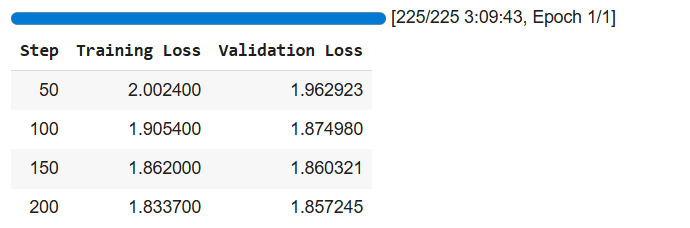

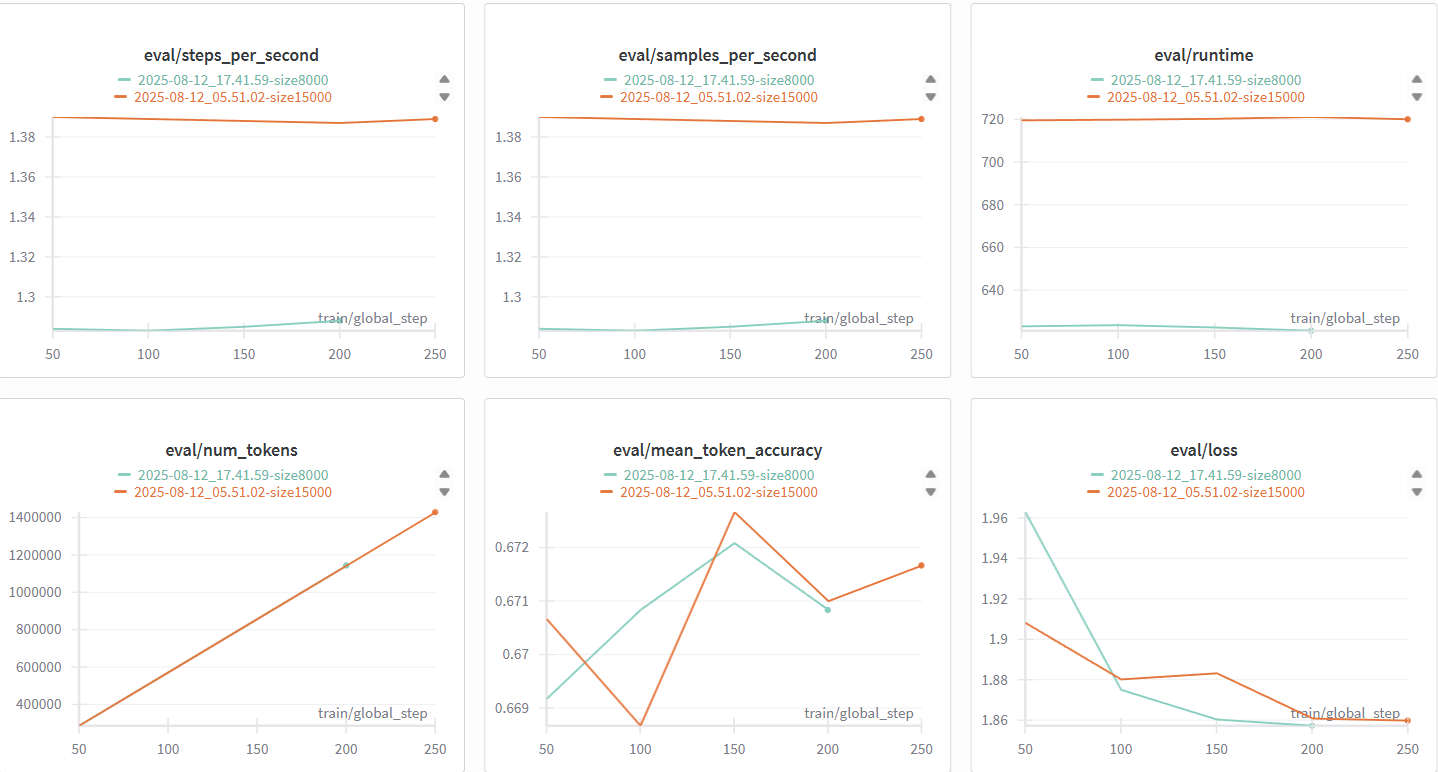

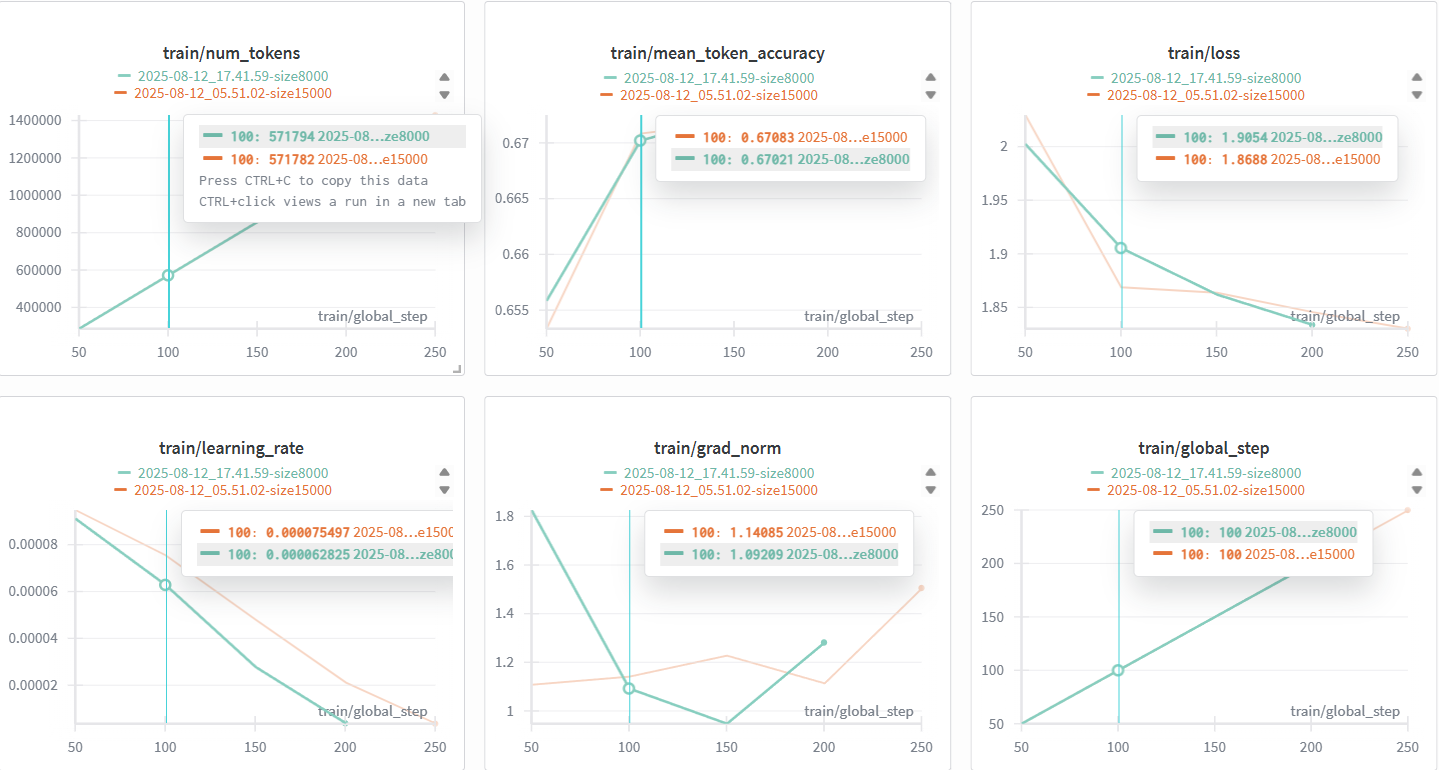

In [ ]:
if LOG_TO_WANDB:
    wandb.finish()